In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import LocalOutlierFactor

warnings.filterwarnings("ignore", category=FutureWarning)
sns.set(style="whitegrid")
print("Librerías cargadas correctamente.")

Librerías cargadas correctamente.


In [25]:
ruta_datos = r"C:\Users\User\Documents\Proyectos_Programacion\MIMIC-Deteccion-anomalias\datos\df_mimic_limpio.csv"

# Leer el archivo CSV
df_mimic = pd.read_csv(ruta_datos)

print("✅ Dataset cargado correctamente.")
print(f"Dimensiones: {df_mimic.shape}")
print("\nVista rápida de las primeras filas:")
display(df_mimic.head())

✅ Dataset cargado correctamente.
Dimensiones: (72922, 16)

Vista rápida de las primeras filas:


,SUBJECT_ID,HADM_ID,CHARTTIME,HEART_RATE,HEART_RATE_UOM,TEMPERATURE,TEMPERATURE_UOM,OXYGEN_SAT,OXYGEN_SAT_UOM,DIASTOLIC_BP,BLOOD_DIASTOLIC_UOM,SYSTOLIC_BP,BLOOD_SYSTOLIC_UOM,GLUCOSE,GLUCOSE_UOM,PATIENT_STATE
0,2,163353,2138-07-17 20:00:00,148.0,bpm,38.500000,°C,97.2,%,61.00,unitless,115.60,unitless,180.2,mg/dL,Taquicardia
1,2,163353,2138-07-17 21:00:00,144.0,bpm,38.200001,°C,96.6,%,58.25,unitless,101.75,unitless,115.8,mg/dL,Taquicardia
2,2,163353,2138-07-17 22:00:00,140.0,bpm,37.700001,°C,93.6,%,68.20,unitless,117.80,unitless,110.2,mg/dL,Taquicardia
3,3,145834,2101-10-20 18:00:00,95.0,bpm,36.200001,°C,98.0,%,0.00,unitless,0.00,unitless,140.0,mg/dL,Normal
4,3,145834,2101-10-20 19:00:00,151.0,bpm,36.200001,°C,82.0,%,0.00,unitless,0.00,unitless,140.0,mg/dL,Normal


In [26]:
biomarcadores = [
    "HEART_RATE",
    "TEMPERATURE",
    "GLUCOSE",
    "OXYGEN_SAT",
    "SYSTOLIC_BP",
    "DIASTOLIC_BP"
]

columna_objetivo = "PATIENT_STATE"
colors = sns.color_palette("Set2", 3)  # 3 colores para las 3 clases


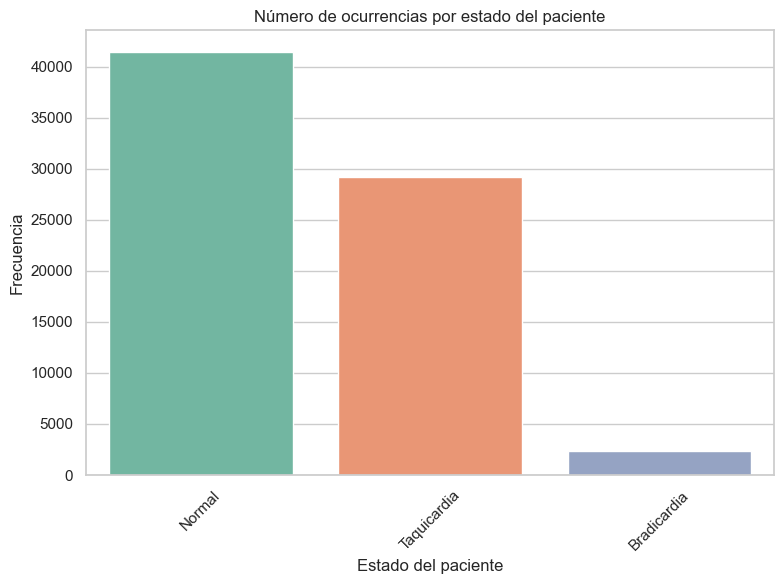

Tabla de frecuencias de 'PATIENT_STATE' :

  PATIENT_STATE  count  percentage
0        Normal  41463       56.86
1   Taquicardia  29155       39.98
2   Bradicardia   2304        3.16


In [27]:
# Ordenar las etiquetas de mayor a menor
order = df_mimic["PATIENT_STATE"].value_counts().index

plt.figure(figsize=(8,6))
sns.countplot(
    x="PATIENT_STATE",
    data=df_mimic,
    order=order,
    palette=colors
)

plt.title("Número de ocurrencias por estado del paciente")
plt.xlabel("Estado del paciente")
plt.ylabel("Frecuencia")

# Rotar etiquetas si hay muchas
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
# --- Tabla de conteos y proporciones ---
state_counts = (
    df_mimic["PATIENT_STATE"]
    .value_counts()
    .reset_index()  # crea columnas: "index" y "PATIENT_STATE"
)

# Renombrar columnas de forma explícita
state_counts.columns = ["PATIENT_STATE", "count"]

# Añadir columna con porcentaje
state_counts["percentage"] = (state_counts["count"] / state_counts["count"].sum() * 100).round(2)

print("Tabla de frecuencias de 'PATIENT_STATE' :\n")
print (state_counts)


Se observa un claro desbalance entre las clases, lo cual deberá abordarse en etapas posteriores del análisis mediante técnicas de balanceo adecuadas. No obstante, para los fines de este notebook —centrado en la detección de datos atípicos— no se aplicarán estrategias de balanceo ni se eliminarán registros pertenecientes a la clase minoritaria. Esto se debe a que el propósito principal es identificar patrones o comportamientos atípicos en los tres grupos de pacientes definidos por su estado al ingreso: bradicardia, taquicardia y condición normal, considerando además que pueden presentar otros signos vitales críticos en el momento de su hospitalización.

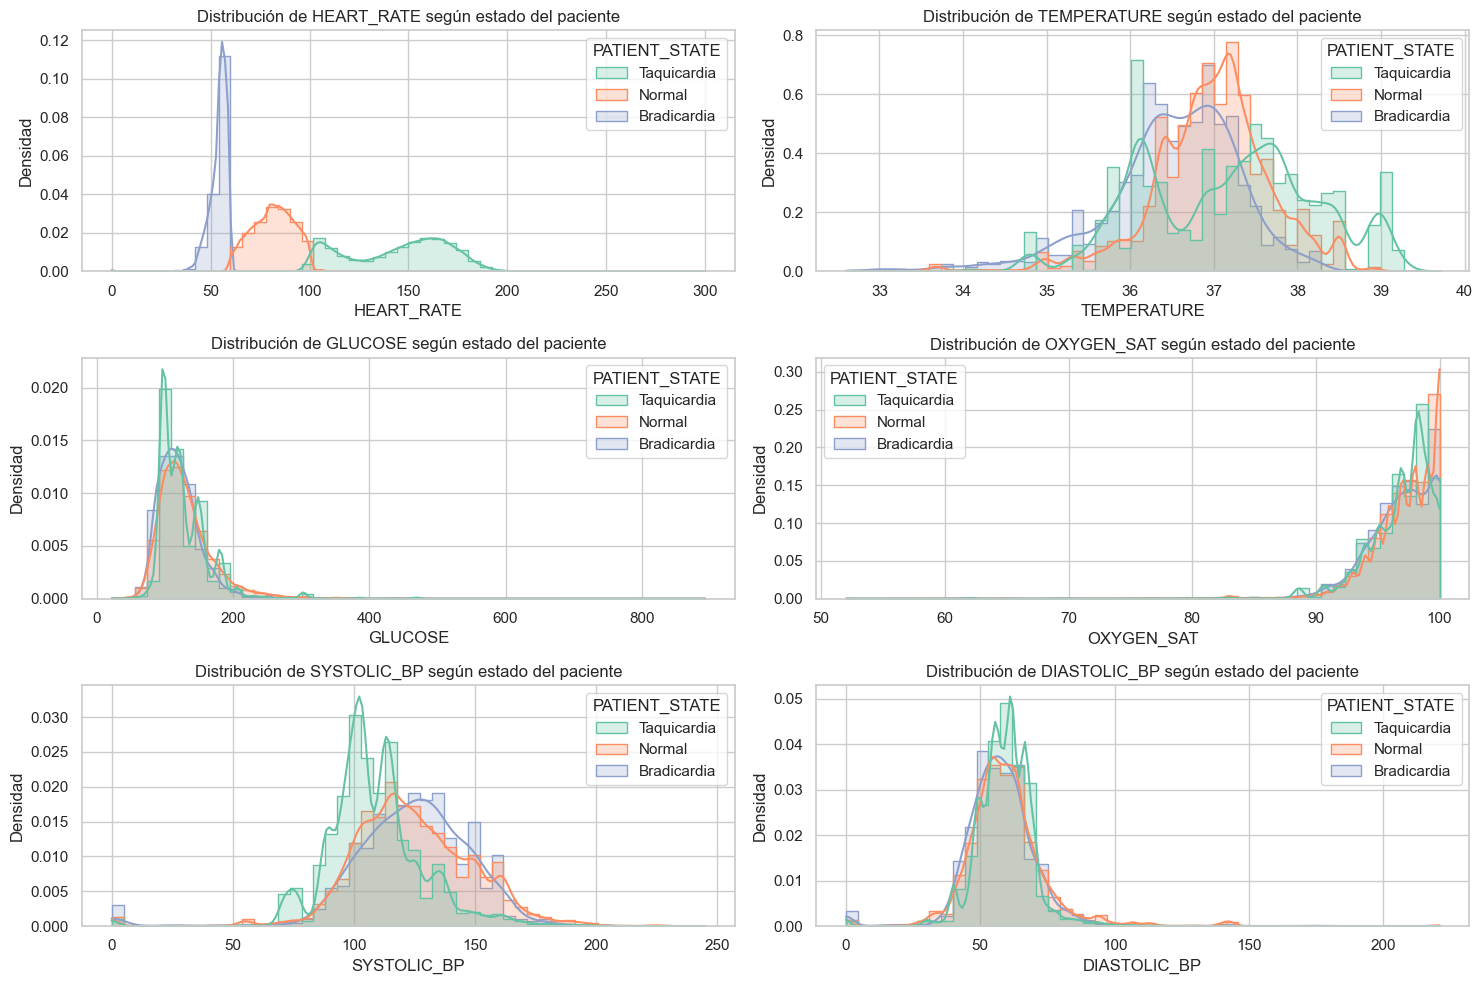

In [28]:
# Paleta de colores
colors = sns.color_palette("Set2", 3)  # 3 colores para las 3 clases
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
axes = axes.flatten()

# Graficar cada biomarcador con las 3 distribuciones según PATIENT_STATE
for i, col in enumerate(biomarcadores):
    sns.histplot(
        data=df_mimic,
        x=col,
        hue="PATIENT_STATE",  # agrupar por estado del paciente
        kde=True,
        bins=50,
        ax=axes[i],
        palette=colors,
        element="step",
        stat="density",  # normaliza para comparar mejor las curvas
        common_norm=False  # evita normalizar juntas las categorías
    )
    axes[i].set_title(f'Distribución de {col} según estado del paciente')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Densidad')

# Eliminar subplots vacíos si sobran
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Hay variaciones leves que diferenciasn las distribuciones de los biomarcadores entre los distintos estados del paciente. Por ejemplo, en el caso de la frecuencia cardíaca (HEART_RATE), se observa que los pacientes con taquicardia presentan una distribución desplazada hacia valores más altos en comparación con los pacientes en estado normal o con bradicardia, lo cual es consistente con la definición clínica de taquicardia.   

En otras es dificil diferenciar variaciones entre las distribuciones pues son casi identicas o con leves variaciones

Text(0.5, 1.0, 'Matriz de correlación (Spearman) entre biomarcadores')

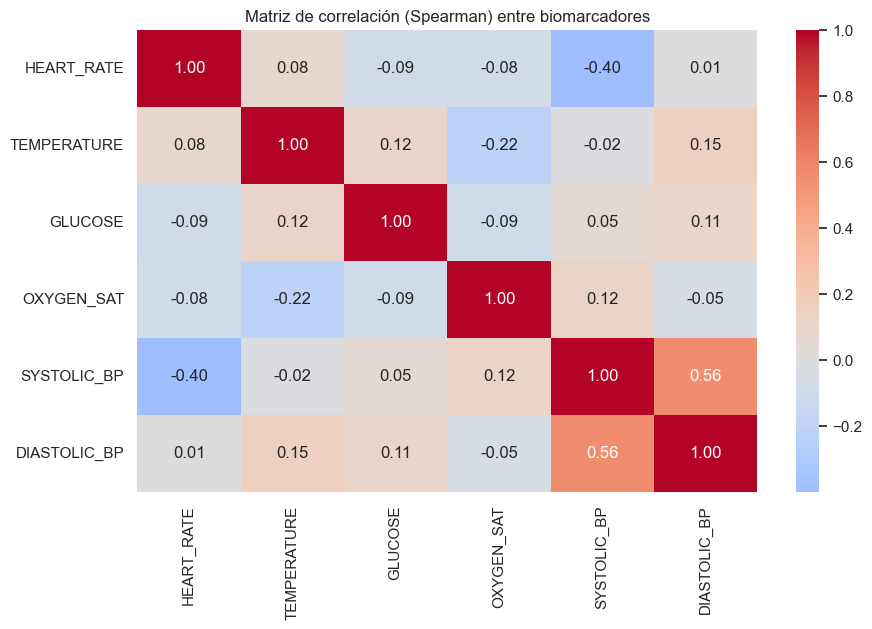

In [6]:
corr_spearman = df_mimic[biomarcadores].corr(method='spearman')

# Visualizar la matriz con un mapa de calor
plt.figure(figsize=(10, 6))
sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Matriz de correlación (Spearman) entre biomarcadores")

# 🩺 Análisis  del coeficiente de Spearman entre biomarcadores
Como se puede observar en la matriz de correlación de Spearman, en general las relaciones entre los distintos biomarcadores tienden a ser débiles o moderadas. Sin embargo, existen asociaciones que merecen consideración clínica. Por ejemplo, se evidencia una correlación negativa débil entre la frecuencia cardíaca (HEART_RATE) y la presión sistólica (SYSTOLIC_BP), lo cual puede explicarse por el reflejo barorreceptor, un mecanismo fisiológico mediante el cual el cuerpo regula la frecuencia cardíaca ante variaciones en la presión arterial, buscando mantener la estabilidad hemodinámica. [1]

Otro punto relevante es la correlación moderada entre la presión sistólica y la diastólica, que era esperable dado que ambas provienen del mismo ciclo cardíaco y suelen variar conjuntamente según la resistencia vascular y el volumen sanguíneo. [2]

Por otro lado, la temperatura corporal presenta una correlación negativa débil con la saturación de oxígeno, lo que puede tener una explicación fisiológica relacionada con el efecto Bohr, en el que el aumento de la temperatura corporal disminuye la afinidad de la hemoglobina por el oxígeno, reduciendo ligeramente la saturación [3]

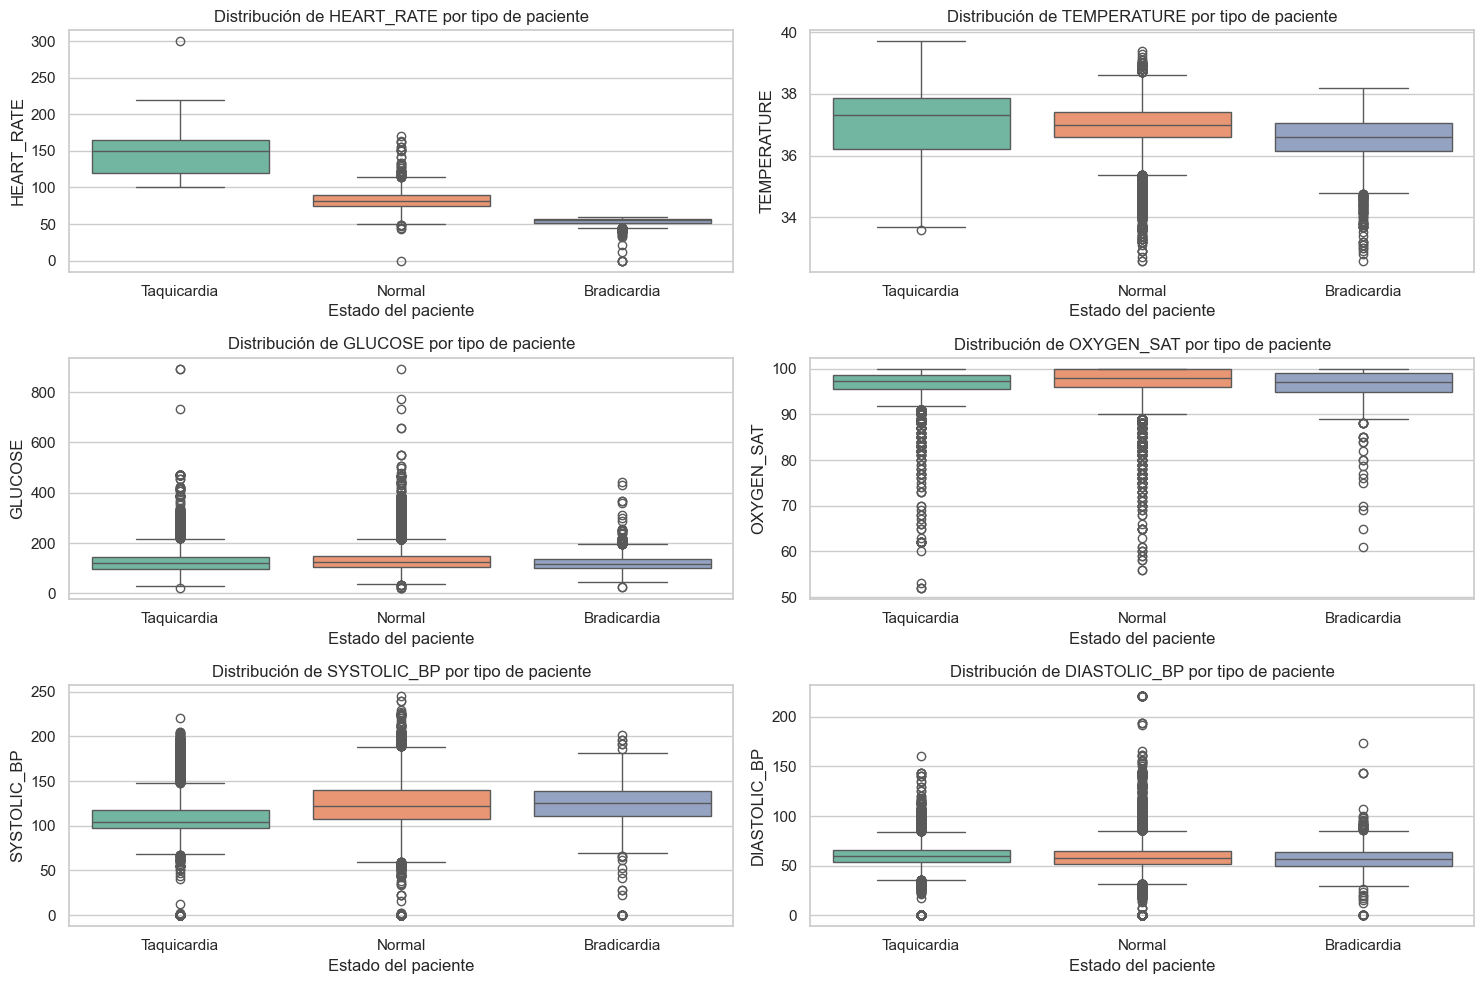

In [8]:
colors = sns.color_palette("Set2", len(df_mimic['PATIENT_STATE'].unique()))

fig, axes = plt.subplots(3, 2, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(biomarcadores):
    sns.boxplot(
        data=df_mimic,
        x='PATIENT_STATE',
        y=col,
        palette=colors,
        ax=axes[i]
    )
    axes[i].set_title(f'Distribución de {col} por tipo de paciente')
    axes[i].set_xlabel('Estado del paciente')
    axes[i].set_ylabel(col)

# Eliminar subplots vacíos si hay menos biomarcadores que espacios
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# 📊 Análisis de la distribución de biomarcadores por tipo de paciente

En los boxplots se observa que los pacientes con bradicardia tienden a presentar temperaturas más bajas en comparación con los otros grupos, mientras que aquellos con taquicardia muestran algunos valores más elevados, alcanzando incluso los 40 °C, lo que podría indicar episodios febriles asociados al aumento de la frecuencia cardíaca. Por su parte, los pacientes con estado normal presentan temperaturas dentro de los rangos fisiológicos esperados.

En cuanto a la glucosa, no se aprecian diferencias significativas entre las clases, mostrando una distribución relativamente homogénea, lo que sugiere que este parámetro no tiene una relación directa con el tipo de alteración cardíaca en el momento del ingreso.

Por otro lado, la presión sistólica (SYSTOLIC_BP) y la presión diastólica (DIASTOLIC_BP) presentan una mayor variabilidad en los pacientes con taquicardia, lo que podría reflejar una respuesta cardiovascular compensatoria frente a situaciones de estrés fisiológico o desbalance hemodinámico. En contraste, los pacientes con bradicardia tienden a mostrar valores más estables y concentrados.

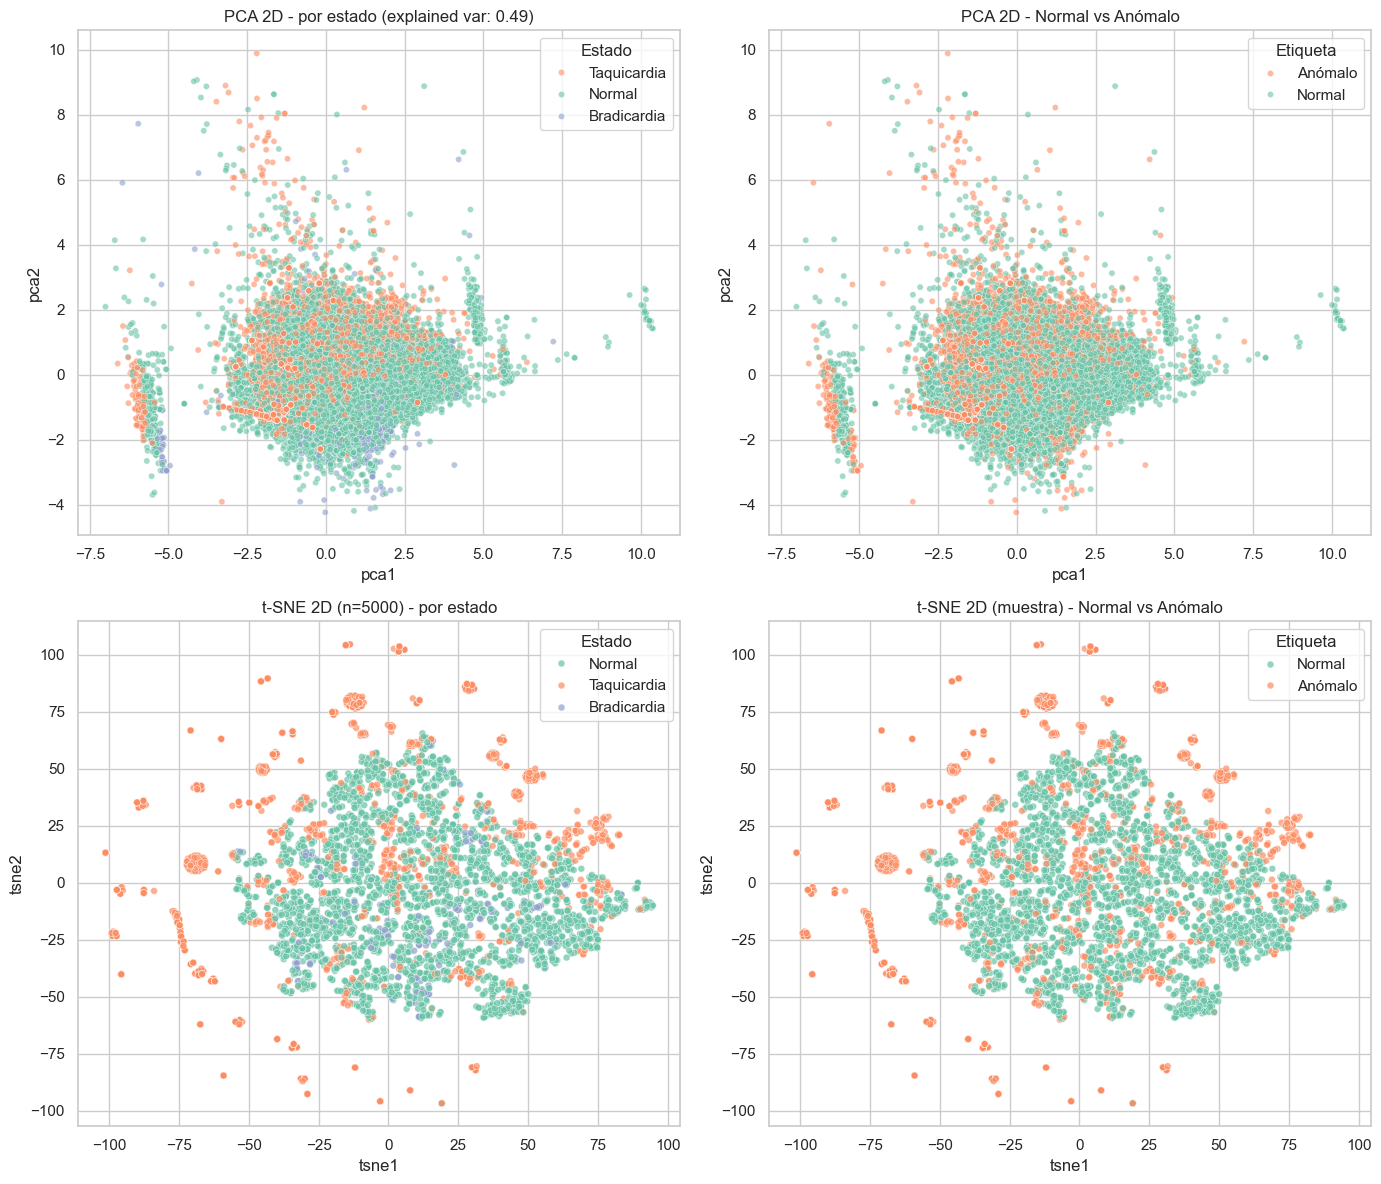

In [ ]:
# Reducción de dimensionalidad: PCA y t-SNE (visualizar Normal vs Anómalo)

# biomarcadores y etiquetas
X = df_mimic[biomarcadores]
y = df_mimic[columna_objetivo]

# Etiqueta binaria: Normal vs Anómalo
y_bin = y.apply(lambda s: "Normal" if s == "Normal" else "Anómalo")

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA 2D sobre todo el dataset (rápido)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Preparar una muestra estratificada para t-SNE (por rendimiento)
sample_size = min(5000, len(df_mimic))
sss = StratifiedShuffleSplit(n_splits=1, train_size=sample_size, random_state=42)
sample_idx = next(sss.split(X_scaled, y))[0]

X_sub = X_scaled[sample_idx]
y_sub = y.iloc[sample_idx]
y_sub_bin = y_bin.iloc[sample_idx]

# t-SNE 2D sobre la muestra
tsne = TSNE(n_components=2, perplexity=30, init="pca", random_state=42)
X_tsne = tsne.fit_transform(X_sub)

# DataFrames auxiliares para graficar
df_pca = df_mimic.loc[:, []].copy()
df_pca["pca1"] = X_pca[:, 0]
df_pca["pca2"] = X_pca[:, 1]
df_pca["PATIENT_STATE"] = y.values
df_pca["anomaly"] = y_bin.values

df_tsne = pd.DataFrame({
    "tsne1": X_tsne[:, 0],
    "tsne2": X_tsne[:, 1],
    "PATIENT_STATE": y_sub.values,
    "anomaly": y_sub_bin.values
})

# Paletas (reusar colores existentes)
palette_three = {cls: colors[i] for i, cls in enumerate(order)}  # Normal, Taquicardia, Bradicardia
palette_bin = {"Normal": colors[0], "Anómalo": colors[1]}

# Graficar: PCA (todas las muestras) y t-SNE (muestra estratificada)
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

# PCA - 3 clases
sns.scatterplot(data=df_pca, x="pca1", y="pca2", hue="PATIENT_STATE",
                palette=palette_three, alpha=0.6, s=20, ax=axs[0, 0])
axs[0, 0].set_title(f"PCA 2D - por estado (explained var: {pca.explained_variance_ratio_.sum():.2f})")
axs[0, 0].legend(loc="best", title="Estado")

# PCA - binario
sns.scatterplot(data=df_pca, x="pca1", y="pca2", hue="anomaly",
                palette=palette_bin, alpha=0.6, s=20, ax=axs[0, 1])
axs[0, 1].set_title("PCA 2D - Normal vs Anómalo")
axs[0, 1].legend(loc="best", title="Etiqueta")

# t-SNE - 3 clases (muestra)
sns.scatterplot(data=df_tsne, x="tsne1", y="tsne2", hue="PATIENT_STATE",
                palette=palette_three, alpha=0.7, s=25, ax=axs[1, 0])
axs[1, 0].set_title(f"t-SNE 2D (n={len(df_tsne)}) - por estado")
axs[1, 0].legend(loc="best", title="Estado")

# t-SNE - binario (muestra)
sns.scatterplot(data=df_tsne, x="tsne1", y="tsne2", hue="anomaly",
                palette=palette_bin, alpha=0.7, s=25, ax=axs[1, 1])
axs[1, 1].set_title("t-SNE 2D (muestra) - Normal vs Anómalo")
axs[1, 1].legend(loc="best", title="Etiqueta")

plt.tight_layout()
plt.show()

Número de outliers detectados por LOF: 3647


c:\Users\User\anaconda3\Lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


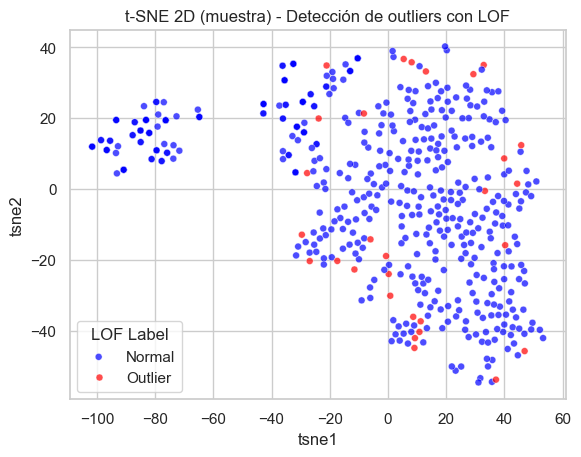

In [14]:
from sklearn.neighbors import LocalOutlierFactor

# Aplicar LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
y_pred_lof = lof.fit_predict(X_scaled)

# Los valores -1 son outliers, 1 son normales
print("Número de outliers detectados por LOF:", np.sum(y_pred_lof == -1))
#Graficamos los resultados LOF en tsne
df_tsne_lof = df_tsne.copy()
df_tsne_lof["LOF_Label"] = y_pred_lof[sample_idx]
palette_lof = {1: "blue", -1: "red"}  # Normal: azul, Outlier: rojo
sns.scatterplot(data=df_tsne_lof, x="tsne1", y="tsne2", hue="LOF_Label",
                palette=palette_lof, alpha=0.7, s=25)
plt.title("t-SNE 2D (muestra) - Detección de outliers con LOF")
plt.legend(loc="best", title="LOF Label", labels=["Normal", "Outlier"])
plt.show()  

In [29]:
from sklearn.preprocessing import StandardScaler

df_num = df_mimic.copy()

# Rellenar posibles nulos con la mediana
df_num[biomarcadores] = df_num[biomarcadores].fillna(df_num[biomarcadores].median())

# Escalado para LOF
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_num[biomarcadores])

In [ ]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
y_pred = lof.fit_predict(X_scaled)
scores = lof.negative_outlier_factor_

df_num['lof_label'] = y_pred
df_num['lof_score'] = scores


c:\Users\User\anaconda3\Lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


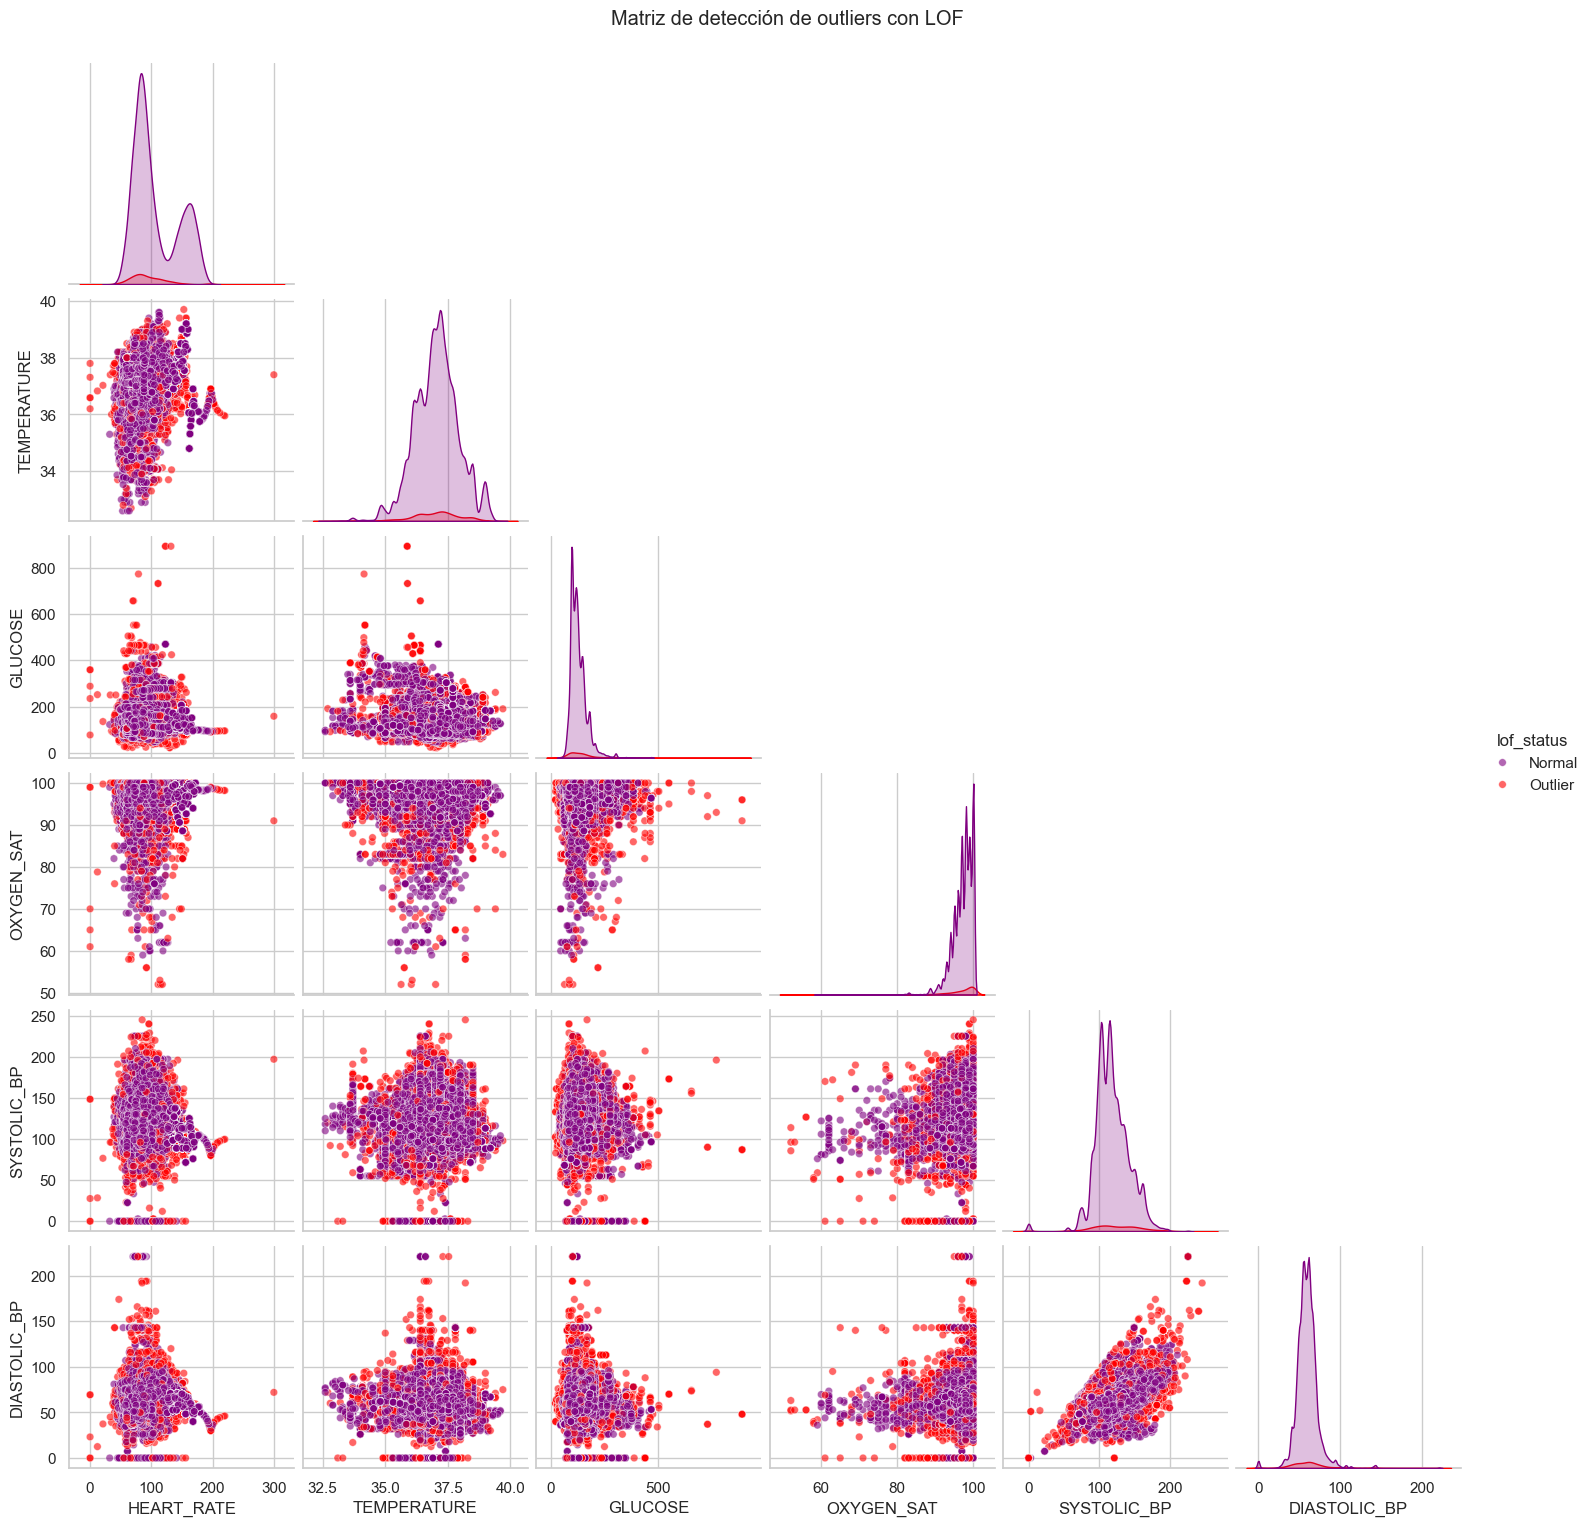

In [42]:
# ==========================
# Celda 4: Visualización tipo matriz
# ==========================
# Mapeamos los labels
label_map = {1: 'Normal', -1: 'Outlier'}
df_num['lof_status'] = df_num['lof_label'].map(label_map)

# Creamos un grid de pares de variables numéricas
g = sns.pairplot(
    data=df_num,
    vars=biomarcadores,
    hue="lof_status",
    corner=True,
    palette={'Normal': 'purple', 'Outlier': 'red'},
    plot_kws={'alpha': 0.6, 's': 30}
)
g.fig.suptitle("Matriz de detección de outliers con LOF", y=1.02)
plt.show()


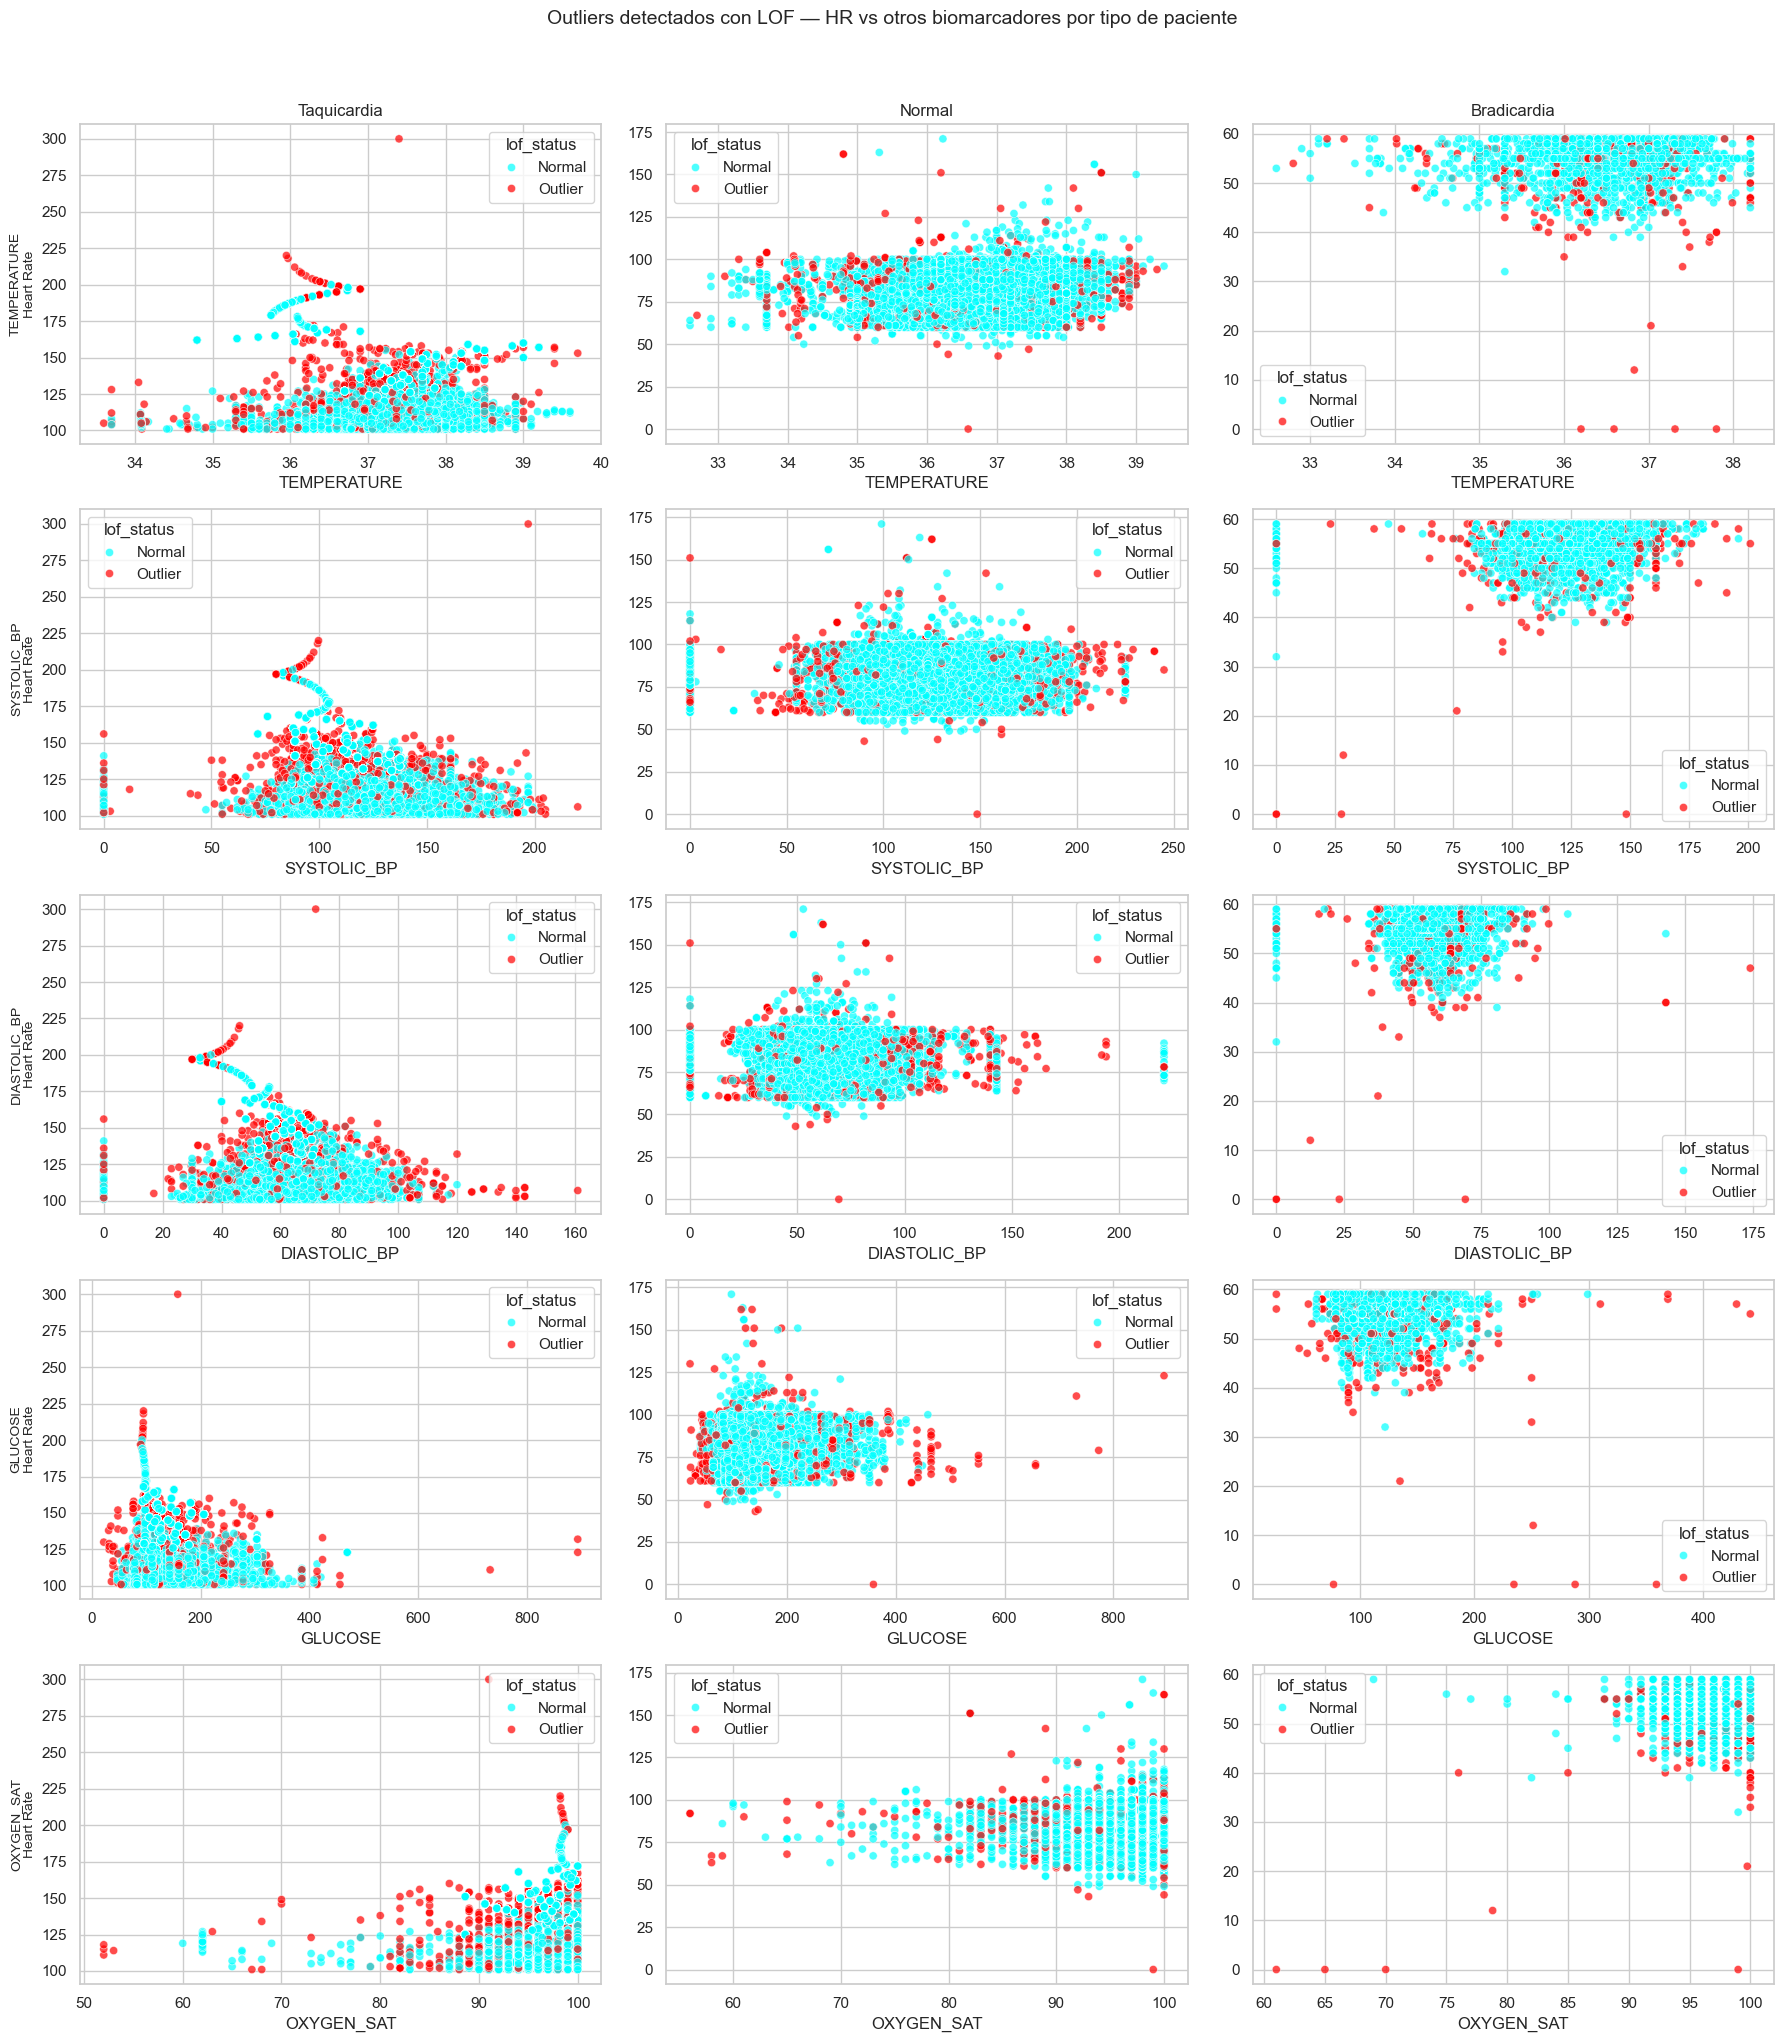

In [56]:
biomarcadores_sin_HR = ['TEMPERATURE', 'SYSTOLIC_BP', 'DIASTOLIC_BP', 'GLUCOSE', 'OXYGEN_SAT']
n_rows = len(biomarcadores_sin_HR)
n_cols = len(df_num['PATIENT_STATE'].unique())

plt.figure(figsize=(6 * n_cols, 4 * n_rows))

for row, feature in enumerate(biomarcadores_sin_HR):
    for col, state in enumerate(df_num['PATIENT_STATE'].unique()):
        plt.subplot(n_rows, n_cols, row * n_cols + col + 1)
        subset = df_num[df_num['PATIENT_STATE'] == state]
        
        sns.scatterplot(
            data=subset,
            x=feature,
            y='HEART_RATE',
            hue='lof_status',
            palette={'Normal': 'cyan', 'Outlier': 'red'},
            alpha=0.7,
            s=35
        )
        
        # Etiquetas y títulos
        if row == 0:
            plt.title(state, fontsize=12)
        if col == 0:
            plt.ylabel(f'{feature}\nHeart Rate', fontsize=10)
        else:
            plt.ylabel('')
        plt.xlabel(feature)
        
plt.suptitle('Outliers detectados con LOF — HR vs otros biomarcadores por tipo de paciente', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

En la gráfica se puede observar que el modelo Local Outlier Factor (LOF) logra identificar varios valores que se desvían de los rangos fisiológicos esperados. En particular, en las variables de glucosa se destacan puntos con niveles significativamente altos, lo cual tiene sentido clínico, pues concentraciones elevadas de glucosa en sangre suelen considerarse anómalas en cualquier estado fisiológico. De igual forma, en la temperatura corporal, especialmente dentro de los grupos Normal y Bradicardia, se observan detecciones de outliers en valores alejados del rango corporal normal (aproximadamente entre 36 °C y 37.5 °C), lo que indica que el modelo es capaz de captar desviaciones térmicas extremas de manera coherente.

Sin embargo, en otras variables como la presión sistólica o la saturación de oxígeno, se evidencian dispersiones amplias donde el modelo marca puntos atípicos que no necesariamente corresponden a anomalías clínicas. Esto ocurre porque el algoritmo se basa en la densidad local de los datos y no en criterios fisiológicos, lo que puede llevar a clasificar como “outlier” valores que en realidad son normales dependiendo del estado del paciente (por ejemplo, una frecuencia cardíaca elevada en taquicardia).

En general, LOF demuestra ser una técnica útil para resaltar registros que podrían considerarse inusuales, pero también evidencia ciertas limitaciones cuando se aplica a signos vitales, donde las variaciones fisiológicas naturales son amplias. Su principal debilidad radica en que no incorpora conocimiento médico, por lo que puede sobredetectar anomalías en variables con alta variabilidad o solapamiento entre clases.


# Bibliografia
[1] G. Mancia et al., “Baroreflex mechanisms in human cardiovascular regulation,” Circulation Research, vol. 116, no. 6, pp. 976–990, 2015. [Online]. Available: https://doi.org/10.1161/CIRCRESAHA.115.305374

[2] A. C. Guyton and J. E. Hall, Textbook of Medical Physiology, 14th ed. Philadelphia, PA: Elsevier, 2021.

[3] J. B. West, Respiratory Physiology: The Essentials, 10th ed. Philadelphia, PA: Wolters Kluwer, 2015.